In [1]:
import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm

from facemesh import FaceMeshBlock
from pupil_detection import IrisLM, IrisBlock
from utils import pad_image

filterwarnings('ignore')
tqdm.pandas()

In [2]:
class FaceMesh(nn.Module):
    """The FaceMesh face landmark model from MediaPipe.

    Because we won't be training this model, it doesn't need to have
    batchnorm layers. These have already been "folded" into the conv 
    weights by TFLite.

    The conversion to PyTorch is fairly straightforward, but there are 
    some small differences between TFLite and PyTorch in how they handle
    padding on conv layers with stride 2.

    This version works on batches, while the MediaPipe version can only
    handle a single image at a time.
    """
    def __init__(self):
        super(FaceMesh, self).__init__()

        self.num_coords = 468
        self.x_scale = 192.0
        self.y_scale = 192.0
        self.min_score_thresh = 0.75

        self._define_layers()

    def _define_layers(self):
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.PReLU(16),

            FaceMeshBlock(16, 16),
            FaceMeshBlock(16, 16),
            FaceMeshBlock(16, 32, stride=2),
            FaceMeshBlock(32, 32),
            FaceMeshBlock(32, 32),
            FaceMeshBlock(32, 64, stride=2),
            FaceMeshBlock(64, 64),
            FaceMeshBlock(64, 64),
            FaceMeshBlock(64, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
        )
        
        self.coord_head = nn.Sequential(
            FaceMeshBlock(128, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
            nn.Conv2d(128, 32, 1),
            nn.PReLU(32),
            FaceMeshBlock(32, 32),
            nn.Conv2d(32, 1404, 3)
        )
        
        self.conf_head = nn.Sequential(
            FaceMeshBlock(128, 128, stride=2),
            nn.Conv2d(128, 32, 1),
            nn.PReLU(32),
            FaceMeshBlock(32, 32),
            nn.Conv2d(32, 1, 3)
        )
        # self.regression_head = nn.Sequential(
        #     FaceMeshBlock(128, 128, stride=2),
        #     FaceMeshBlock(128, 128),
        #     FaceMeshBlock(128, 128),
        #     nn.Conv2d(128, 32, 1),
        #     nn.PReLU(32),
        #     FaceMeshBlock(32, 32),
        # )
        # self.fc = nn.Linear(32 * 3 * 3, 2)
        
    def forward(self, x):
        # TFLite uses slightly different padding on the first conv layer
        # than PyTorch, so do it manually.
        x = nn.ReflectionPad2d((1, 0, 1, 0))(x)
        b = x.shape[0]      # batch size, needed for reshaping later

        x = self.backbone(x)            # (b, 128, 6, 6)
        
        c = self.conf_head(x)           # (b, 1, 1, 1)
        c = c.view(b, -1)               # (b, 1)
        
        r = self.coord_head(x)          # (b, 1404, 1, 1)
        r = r.reshape(b, -1)            # (b, 1404)

        # pred = self.regression_head(x)
        # pred = pred.view(-1, 32 * 3 * 3)
        # pred = self.fc(pred)
        # return pred
        return [r, c]

    def _device(self):
        """Which device (CPU or GPU) is being used by this model?"""
        return self.conf_head[1].weight.device
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()        
    
    def preprocess(self, x):
        """Converts the image pixels to the range [-1, 1]."""
        return x.float() / 127.5 - 1.0

    def predict_on_image(self, img):
        """Makes a prediction on a single image.

        Arguments:
            img: a NumPy array of shape (H, W, 3) or a PyTorch tensor of
                 shape (3, H, W). The image's height and width should be 
                 128 pixels.

        Returns:
            A tensor with face detections.
        """
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute((2, 0, 1))

        return self.predict_on_batch(img.unsqueeze(0))[0]

    def predict_on_batch(self, x):
        """Makes a prediction on a batch of images.

        Arguments:
            x: a NumPy array of shape (b, H, W, 3) or a PyTorch tensor of
               shape (b, 3, H, W). The height and width should be 128 pixels.

        Returns:
            A list containing a tensor of face detections for each image in 
            the batch. If no faces are found for an image, returns a tensor
            of shape (0, 17).

        Each face detection is a PyTorch tensor consisting of 17 numbers:
            - ymin, xmin, ymax, xmax
            - x,y-coordinates for the 6 keypoints
            - confidence score
        """
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).permute((0, 3, 1, 2))

        assert x.shape[1] == 3
        assert x.shape[2] == 192
        assert x.shape[3] == 192

        # 1. Preprocess the images into tensors:
        x = x.to(self._device())
        x = self._preprocess(x)

        # 2. Run the neural network:
        with torch.no_grad():
            out = self.__call__(x)

        # 3. Postprocess the raw predictions:
        detections, confidences = out
        detections[0:-1:3] *= self.x_scale
        detections[1:-1:3] *= self.y_scale

        return detections.view(-1, 3), confidences

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [10]:
pretrained_model_face = FaceMesh()
pretrained_model_face.load_weights("./weights/facemesh.pth")

model_path = "./weights/irislandmarks.pth"
pretrained_model_eyes = IrisLM()
weights = torch.load(model_path)
pretrained_model_eyes.load_state_dict(weights)

<All keys matched successfully>

In [3]:
class FaceGridModel(nn.Module):
    def __init__(self, gridSize = 25):
        super(FaceGridModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(gridSize * gridSize, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
class EyesModel(nn.Module):
    def __init__(self, pretrained_model_eyes: nn.Module):
        super(EyesModel, self).__init__()
        self.backbone = pretrained_model_eyes.backbone
        self.regression_head_eyes = nn.Sequential(
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
        )
        # connect eyes
        self.fc = nn.Sequential(
            nn.Linear(2 * 128 * 1 * 1, 128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_eye_l, x_eye_r):
        x_eye_l = self.backbone(x_eye_l)
        x_eye_l = self.regression_head_eyes(x_eye_l)
        x_eye_l = x_eye_l.view(-1, 128 * 1 * 1)

        x_eye_r = self.backbone(x_eye_r)
        x_eye_r = self.regression_head_eyes(x_eye_r)
        x_eye_r = x_eye_r.view(-1, 128 * 1 * 1)
        x = torch.cat([x_eye_l, x_eye_r], 1)
        x = self.fc(x)
        return x

In [18]:
class FaceModel(nn.Module):
    def __init__(self, pretrained_model_face: nn.Module):
        super(FaceModel, self).__init__()
        self.backbone = pretrained_model_face.backbone
        self.regression_head_face = nn.Sequential(
            FaceMeshBlock(128, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
            nn.Conv2d(128, 32, 1),
            nn.PReLU(32),
            FaceMeshBlock(32, 32),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
        )

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0

    def forward(self, x_face):
        x_face = self._preprocess(x_face)
        x_face = nn.ReflectionPad2d((1, 0, 1, 0))(x_face)
        x_face = self.backbone(x_face)
        x_face = self.regression_head_face(x_face)
        x_face = x_face.view(-1, 32 * 3 * 3)
        x = self.fc(x_face)
        return x

In [14]:
class FineTuneModel(nn.Module):
    def __init__(self, pretrained_model_face: nn.Module, pretrained_model_eyes: nn.Module):
        super(FineTuneModel, self).__init__()
        self.face_model = FaceModel(pretrained_model_face)
        self.eyes_model = EyesModel(pretrained_model_eyes)
        self.face_grid_model = FaceGridModel()
        self.fc = nn.Sequential(
            nn.Linear(128+64+128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0
        
    def forward(self, x_face, x_eye_l, x_eye_r, x_grid):
        x_eyes = self.eyes_model(x_eye_l, x_eye_r)
        x_face = self.face_model(x_face)
        x_grid = self.face_grid_model(x_grid)
        x = torch.cat([x_eyes, x_face, x_grid], axis = 1)
        x = self.fc(x)
        return x

In [20]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes).to(device)

In [21]:
rand_img = np.random.randint(0, 255, (2, 3, 192,192))
x_face = torch.from_numpy(rand_img).to(device)
rand_img = (np.random.randint(0, 255, (2, 3, 64, 64)) / 255.)
x_eye = torch.from_numpy(rand_img).type(torch.float32).to(device)
rand_grid = (np.random.randint(0, 255, (2, 25, 25)) / 255.)
x_grid = torch.from_numpy(rand_grid).type(torch.float32).to(device)

In [22]:
model(x_face, x_eye, x_eye, x_grid)

tensor([[ 0.5676, -0.3433],
        [ 0.4620, -0.4052]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
data = pd.read_csv("./tobii_train_sub_updv2.csv")

In [24]:
data.head()

,paths,x_normalized,y_normalized,full_name
0,/home/ubuntu/projects/tweakle/data/tobii_image...,0.412840,0.290486,P_06#1491573819193_21_-study-where_to_find_mor...
1,/home/ubuntu/projects/tweakle/data/tobii_image...,0.273776,0.422115,P_57#1493143714690_2_-study-dot_test_instructi...
2,/home/ubuntu/projects/tweakle/data/tobii_image...,0.331355,0.406230,P_52#1493064746365_25_-study-tooth_abscess#fra...
3,/home/ubuntu/projects/tweakle/data/tobii_image...,0.338654,0.359082,P_46#1492780566148_16_-study-where_to_find_mor...
4,/home/ubuntu/projects/tweakle/data/tobii_image...,0.320225,0.340346,P_13#1491923431229_24_-study-where_to_find_mor...


In [11]:
# data["x_normalized"] = (data["tob_right_x"] + data["tob_left_x"]) / 2
# data["y_normalized"] = (data["tob_right_y"] + data["tob_left_y"]) / 2

In [12]:
# import os
# data["paths"] = data["full_name"].apply(lambda x: f"/home/ubuntu/projects/tweakle/data/tobii_images/{x}")
# data["paths"].head()

0    /home/ubuntu/projects/tweakle/data/tobii_image...
1    /home/ubuntu/projects/tweakle/data/tobii_image...
2    /home/ubuntu/projects/tweakle/data/tobii_image...
3    /home/ubuntu/projects/tweakle/data/tobii_image...
4    /home/ubuntu/projects/tweakle/data/tobii_image...
Name: paths, dtype: object

In [65]:
from typing import List, Optional

class GazeDetectionDataset(Dataset):
    """Gaze detection dataset."""

    def __init__(
        self,
        data: pd.DataFrame,
        transform_list: Optional[List]= None,
        to_tensors: bool = False,
        device: str = "cpu",
    ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data.copy()
        self.to_tensors = to_tensors
        transform_list_ = transform_list.copy()
        if to_tensors:
            transform_list_.append(ToTensorV2())
        transform_list_eyes = []
        if to_tensors:
            transform_list_eyes.append(ToTensorV2())
        self.transform = A.Compose(transform_list_)
        self.transform_eyes = A.Compose(transform_list_eyes)
        transform_list_mask = [A.Resize(25, 25)]
        if to_tensors:
            transform_list_mask.append(ToTensorV2())
        self.transform_mask = A.Compose(transform_list_mask)
        self.device = torch.device(device)
        self.faceCascade = cv2.CascadeClassifier("./weights/haarcascade_frontalface_alt.xml")

    def get_face(self, frame: np.ndarray):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = self.faceCascade.detectMultiScale(
            gray_frame,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
        )
        if len(faces) > 0:
            if len(faces) > 1:
                face_rect = sorted(faces, key = lambda x: x[2] * x[3])[-1]
            else:
                face_rect = faces[0]
            face_center = np.array([
                (face_rect[0] + face_rect[2] // 2) / frame.shape[1],
                (face_rect[1] + face_rect[3] // 2) / frame.shape[0]
            ]).astype(np.float32)
            face_crop = frame[
                max(face_rect[1] - face_rect[3] // 4, 0) : min(face_rect[1] + face_rect[3] + face_rect[3] // 4, frame.shape[0]),
                max(face_rect[0] - face_rect[2] // 4, 0) : min(face_rect[0] + face_rect[2] + face_rect[2] // 4, frame.shape[1]), :
            ]
            return face_crop, face_rect
        else:
            return frame, None

    def get_face_mask(self, frame, face_rect):
        mask = np.zeros((frame.shape[0], frame.shape[1]))
        if face_rect is None:
            return mask
        mask[
            face_rect[1] : face_rect[1] + face_rect[3],
            face_rect[0] : face_rect[0] + face_rect[2]
        ] = 1
        return mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        img_path = row['paths']
        try:
            image_orig = cv2.imread(img_path)
            image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
            image, face_rect = self.get_face(image_orig)
            face_mask = self.get_face_mask(image_orig, face_rect)
            image = image / 255.
            eyes_path = img_path.replace("tobii_images", "eyes_images")
            eye_left_path = eyes_path.replace(".png", "_left.png")
            eye_right_path = eyes_path.replace(".png", "_right.png")
            image_eye_l = cv2.imread(eye_left_path)
            image_eye_l = cv2.cvtColor(image_eye_l, cv2.COLOR_BGR2RGB) / 255.
            image_eye_r = cv2.imread(eye_right_path)
            image_eye_r = cv2.cvtColor(image_eye_r, cv2.COLOR_BGR2RGB) / 255.
        except Exception:
            raise Exception(f"Image {img_path}, {eye_left_path} failed loading")
        coordinates = row[['x_normalized', 'y_normalized']].values.astype(np.float32)
        
        if self.transform:
            image = self.transform(image = image)['image']
            face_mask = self.transform_mask(image = face_mask)['image']
            image_eye_l = self.transform_eyes(image = image_eye_l)['image']
            image_eye_r = self.transform_eyes(image = image_eye_r)['image']
            if self.to_tensors:
                coordinates = torch.from_numpy(coordinates).to(self.device)
                image = image.type(torch.float32).to(self.device)
                image_eye_l = image_eye_l.type(torch.float32).to(self.device)
                image_eye_r = image_eye_r.type(torch.float32).to(self.device)
                face_mask = face_mask.type(torch.float32).to(self.device)
            
        sample = {'image': image, 'coordinates': coordinates,
                  "eye_l": image_eye_l, "eye_r": image_eye_r, "face_mask": face_mask}
        return sample

In [91]:
trans_list = [
        A.Resize(192, 192),
        # ToTensorV2()
    ]

0 (192, 192, 3) (2,)


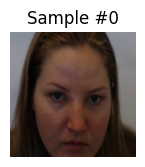

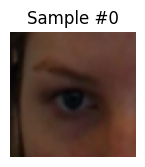

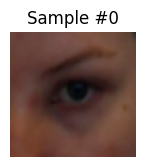

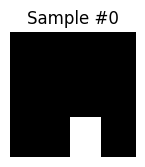

1 (192, 192, 3) (2,)


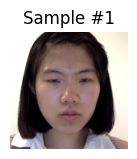

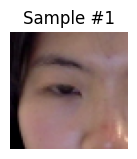

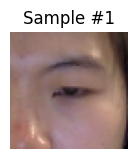

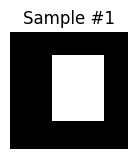

2 (192, 192, 3) (2,)


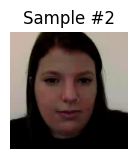

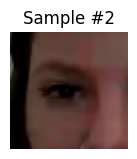

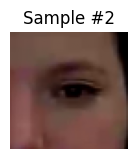

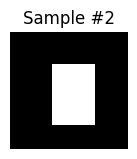

3 (192, 192, 3) (2,)


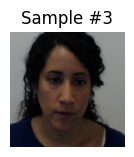

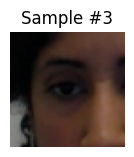

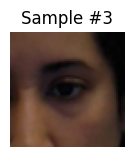

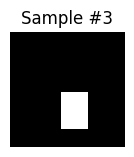

In [92]:
face_dataset = GazeDetectionDataset(data=data, transform_list=trans_list)

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['coordinates'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['image'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_l'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_r'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['face_mask'], cmap = "gray")
    plt.show()
    if i == 3:
        plt.show()
        break

In [93]:
face_dataset = GazeDetectionDataset(data = data, transform_list=trans_list, to_tensors=True, device=device)

In [94]:
for i, sample in enumerate(face_dataset):
    print(i, sample['image'].size(), sample['coordinates'].size(), sample['eye_l'].size(), sample['face_mask'].size())
    if i == 3:
        break

0 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
1 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
2 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
3 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])


In [95]:
def train(model: FineTuneModel, dataloader_train: DataLoader):
    total_loss = 0.0
    model.train()
    preds_list = []
    labels_list = []
    for i, data in enumerate(dataloader_train):
        inputs, labels, inputs_eye_l, inputs_eye_r, inputs_mask = data['image'], data['coordinates'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask']

        optimizer.zero_grad()

        outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        preds_list += outputs.cpu().detach().tolist()
        labels_list += labels.cpu().detach().tolist()
        total_loss += loss.cpu().item()

    loss = total_loss / (i + 1)
    mape_value = mape(labels_list, preds_list)
    return loss, mape_value

In [96]:
def eval(model: FineTuneModel, dataloader_val: DataLoader):
    total_loss = 0.0
    model.eval()
    preds = []
    preds_list = []
    labels_list = []
    for i, data in enumerate(dataloader_val):
        inputs, labels, inputs_eye_l, inputs_eye_r, inputs_mask = data['image'], data['coordinates'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask']
        with torch.no_grad():
            outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.cpu().item()
        preds_list += outputs.cpu().detach().tolist()
        labels_list += labels.cpu().detach().tolist()
        
    loss = total_loss / (i + 1)
    mape_value = mape(labels_list, preds_list)
    return loss, mape_value

In [97]:
from sklearn.model_selection import train_test_split

In [9]:
# data = pd.read_csv("../data/data_clicks.csv")

In [74]:
# df = pd.read_csv("./data_tobii_names.csv")

In [74]:
# df_sub = df.sample(100_000)

In [11]:
# df["x_normalized"] = (df["tob_right_x"] + df["tob_left_x"]) / 2
# df["y_normalized"] = (df["tob_right_y"] + df["tob_left_y"]) / 2

In [12]:
# import os
# df["paths"] = df["full_name"].apply(lambda x: f"/home/ubuntu/projects/tweakle/data/tobii_images/{x}")
# df["paths"].head()

In [127]:
NUM_SAMPLES = None
BATCH_SIZE = 1024
LEARNING_RATE = 1.5e-4
REDUCE_FACTOR = 0.5
PATIENCE = 2
NUM_EPOCHS = 10
WEIGHT_DECAY = 1e-4
CHECKPOINTS_PATH = "./checkpoints/"
EXPERIMENT_NAME = "face_eyes_mask_less_data_correctedv2_tune"

In [88]:
# train_df, test_df = train_test_split(df_sub.head(NUM_SAMPLES), test_size = 0.15, random_state=42, shuffle=True)
# train_df, val_df = train_test_split(train_df, test_size = 0.1, random_state=42, shuffle=True)

In [90]:
# test_df.to_csv("./tobii_test_sub.csv", index = False)
# val_df.to_csv("./tobii_val_sub.csv", index = False)
# train_df.to_csv("./tobii_train_sub.csv", index = False)

In [76]:
test_df = pd.read_csv("./tobii_test_sub_updv2.csv")
val_df = pd.read_csv("./tobii_val_sub_updv2.csv")
train_df = pd.read_csv("./tobii_train_sub_updv2.csv")

In [89]:
def try_load(img_path):
    try:
        eyes_path = img_path.replace("tobii_images", "eyes_images")
        eye_left_path = eyes_path.replace(".png", "_left.png")
        image_eye_l = cv2.imread(eye_left_path)
        image_eye_l = cv2.cvtColor(image_eye_l, cv2.COLOR_BGR2RGB) / 255.
        return True
    except:
        return False

In [96]:
test_df["eyes_exist"] = test_df.paths.apply(try_load)
val_df["eyes_exist"] = val_df.paths.apply(try_load)
train_df["eyes_exist"] = train_df.paths.apply(try_load)

In [51]:
test_df = test_df[test_df["eyes_exist"]]
val_df = val_df[val_df["eyes_exist"]]
train_df = train_df[train_df["eyes_exist"]]

In [99]:
test_df.shape, train_df.shape

((13789, 5), (62786, 5))

In [128]:
dataset_train = GazeDetectionDataset(data = train_df, transform_list=trans_list, to_tensors=True, device=device)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)
dataset_val = GazeDetectionDataset(data = val_df, transform_list=trans_list, to_tensors=True, device=device)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

In [129]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [130]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="4qtNKAjcucKnOrwC4pRvPaHRv",
  project_name="tweakle-gaze-detection",
  workspace="kmisterios"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kmisterios/tweakle-gaze-detection/ebd5cdc339674b459f8dc5796ebdeae6



In [131]:
experiment.set_name(f"{EXPERIMENT_NAME}")

In [132]:
# model = FineTuneModel(pretrained_model_face, pretrained_model_eyes).to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, factor= REDUCE_FACTOR, patience=PATIENCE)

In [133]:
hyper_params = {
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "reduce_factor": REDUCE_FACTOR,
    "patience": PATIENCE,
    "num_epochs": NUM_EPOCHS,
    "num_samples": NUM_SAMPLES,
    "optimizer": optimizer.__str__(),
    "scheduler": scheduler.__str__(),
    "gradient_clip": True,
    "experiment_name": EXPERIMENT_NAME
}
experiment.log_parameters(hyper_params)

In [ ]:
val_loss_min = np.inf
epoch_save = None

for epoch in range(NUM_EPOCHS):
    train_loss, train_mape = train(model, dataloader_train)
    val_loss, val_mape = train(model, dataloader_val)
    scheduler.step(val_loss)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    if val_loss_min > val_loss:
        val_loss_min = val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt"))
        epoch_save = epoch

    print()
    print(f'Epoch: {epoch}: Train loss: {round(train_loss, 3)}; Val loss: {round(val_loss, 3)};')
    if epoch_save is not None:
        print(f'Best model saved on epoch {epoch_save}')
    experiment.log_metrics({
        "rmse_val": val_loss,
        "rmse_train": train_loss,
        "best_model_epoch": epoch_save,
        "train_mape": train_mape,
        "val_mape": val_mape,
        "epoch": epoch,
        "lr": current_lr
    })
experiment.end()

In [ ]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes).to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt")))
# model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_raw_images.pt")))
criterion = RMSELoss()
model.eval()

In [ ]:
dataset_test = GazeDetectionDataset(data = test_df, transform_list=trans_list, to_tensors=True, device=device)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

In [ ]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_test), total = len(dataloader_test)):
    inputs, labels, inputs_eye_l, inputs_eye_r, inputs_mask = data['image'], data['coordinates'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask']
    with torch.no_grad():
        outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

In [ ]:
print(f"Test loss: {round(losses / (i + 1), 3)}")

In [ ]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [ ]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

In [ ]:
test_df_copy = test_df.copy()

In [ ]:
test_df_copy["pred_x"] = preds.T[0]
test_df_copy["pred_y"] = preds.T[1]

In [ ]:
test_df_copy[['x_normalized', 'y_normalized', 'pred_x', 'pred_y']].tail(40)

In [30]:
from sklearn.metrics import mean_squared_error as mse

In [25]:
test1 = test_df_copy[(test_df_copy["x_normalized"] < 1.2) & (test_df_copy["y_normalized"] < 1.1)]
condition = ((test1["x_normalized"] > 0.6) & (test1["pred_x"] < 0.4)) | \
            ((test1["x_normalized"] < 0.4) & (test1["pred_x"] > 0.6))
test2 = test1[~condition]

In [35]:
preds = test_df_copy[["pred_x", "pred_y"]].values
labels = test_df_copy[["x_normalized", "y_normalized"]].values

In [36]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.49439073762864705


In [37]:
rmse_value = mse(labels, preds, squared=True)
print(f"Test RMSE: {rmse_value}")

Test RMSE: 0.030252860148658117


In [38]:
preds = test2[["pred_x", "pred_y"]].values
labels = test2[["x_normalized", "y_normalized"]].values

In [39]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.4947499885250973


In [40]:
rmse_value = mse(labels, preds, squared=True)
print(f"Test RMSE: {rmse_value}")

Test RMSE: 0.019516443613114616


In [132]:
test2.drop(columns = ["pred_x", "pred_y"]).to_csv("./tobii_test_sub_updv2.csv", index = False)

NameError: name 'test2' is not defined

In [123]:
train_df.shape

(62786, 5)

In [124]:
test_df.shape

(13789, 5)

In [ ]:
test_df_copy.to_csv("./tobii_test_sub_updv2_mixed_face_tune_pred.csv", index = False)

In [42]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_val), total = len(dataloader_val)):
    inputs, labels = data['image'], data['coordinates']
    with torch.no_grad():
        outputs = model(inputs)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

100%|█████████████████████████████████████████████| 9/9 [01:20<00:00,  8.95s/it]

Test loss: 0.175


In [122]:
print(f"Val loss: {round(losses / (i + 1), 3)}")

NameError: name 'losses' is not defined

In [44]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [45]:
mape_value = mape(labels, preds)
print(f"Val MAPE: {mape_value}")

Val MAPE: 0.4815107583999634


In [50]:
rmse_value = mse(labels, preds, squared=True)
print(f"Val RMSE: {rmse_value}")

Val RMSE: 0.030162379145622253


In [46]:
val_df_copy = val_df.copy()

In [47]:
val_df_copy["pred_x"] = preds.T[0]
val_df_copy["pred_y"] = preds.T[1]

In [54]:
test1 = val_df_copy[(val_df_copy["x_normalized"] < 1.2) & (val_df_copy["y_normalized"] < 1.1)]
condition = ((test1["x_normalized"] > 0.6) & (test1["pred_x"] < 0.4)) | \
            ((test1["x_normalized"] < 0.4) & (test1["pred_x"] > 0.6))
test2 = test1[~condition]

In [55]:
preds = test2[["pred_x", "pred_y"]].values
labels = test2[["x_normalized", "y_normalized"]].values

In [56]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.8610942596087398


In [57]:
rmse_value = mse(labels, preds, squared=True)
print(f"Test RMSE: {rmse_value}")

Test RMSE: 0.047016402471560886


In [58]:
test2.drop(columns = ["pred_x", "pred_y"]).to_csv("./tobii_val_sub_updv2.csv", index = False)

In [59]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_train), total = len(dataloader_train)):
    inputs, labels = data['image'], data['coordinates']
    with torch.no_grad():
        outputs = model(inputs)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

100%|███████████████████████████████████████████| 75/75 [12:09<00:00,  9.73s/it]

Test loss: 0.166


In [121]:
print(f"Val loss: {round(losses / (i + 1), 3)}")

NameError: name 'losses' is not defined

In [61]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [62]:
mape_value = mape(labels, preds)
print(f"Val MAPE: {mape_value}")

Val MAPE: 0.4815669059753418


In [63]:
rmse_value = mse(labels, preds, squared=True)
print(f"Val RMSE: {rmse_value}")

Val RMSE: 0.02777956984937191


In [64]:
train_df_copy = train_df.copy()

In [65]:
train_df_copy["pred_x"] = preds.T[0]
train_df_copy["pred_y"] = preds.T[1]

In [66]:
test1 = train_df_copy[(train_df_copy["x_normalized"] < 1.2) & (train_df_copy["y_normalized"] < 1.1)]
condition = ((test1["x_normalized"] > 0.6) & (test1["pred_x"] < 0.4)) | \
            ((test1["x_normalized"] < 0.4) & (test1["pred_x"] > 0.6))
test2 = test1[~condition]

In [67]:
preds = test2[["pred_x", "pred_y"]].values
labels = test2[["x_normalized", "y_normalized"]].values

In [68]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.8352110407623952


In [69]:
rmse_value = mse(labels, preds, squared=True)
print(f"Test RMSE: {rmse_value}")

Test RMSE: 0.0466036837919723


In [70]:
test2.drop(columns = ["pred_x", "pred_y"]).to_csv("./tobii_train_sub_updv2.csv", index = False)